# Análise de Estrutura Secundária de Variantes — DRD4
Este notebook implementa um pipeline reprodutível para comparar previsões de estrutura secundária (SS) entre variantes da proteína DRD4.

Principais objetivos:
- Ler arquivos `.ss2` (estados H/E/C e probabilidades P(C), P(H), P(E)).
- Usar `NM_000797.4` como sequência de referência para indexação (pressupõe que os arquivos `.ss2` já estão alinhados entre si).
- Calcular métricas por posição (concordância estrita, consenso probabilístico, entropia, similaridade de cosseno, transições).
- Agregar métricas em janelas móveis e resumir regiões relevantes; gerar gráficos e tabelas exportáveis.

Premissas e comportamento em casos especiais:
- Entrada: arquivos `.ss2` alinhados entre si; se houver indels, as linhas devem já corresponder à mesma posição de referência.
- Gaps/posições ausentes: o código atual assume que cada arquivo tem a mesma quantidade de linhas; posições faltantes devem ser preenchidas previamente ou tratadas antes da análise.
- A ordem das variantes é a lista `variant_names` carregada do diretório `secondary_struct/`; algumas métricas (ex.: transições) contam mudanças nessa ordem — se desejar outra ordem, reindexe `variant_names` antes de rodar.

Saídas principais:
- `df_metricas`: DataFrame por posição com: pos, aa_ref, concordancia_estrita, media_P_C, media_P_H, media_P_E, entropia, media_similaridade_cosseno, transicoes.
- `df_janela`: DataFrame com agregados por janela móvel (start, end, media_concordancia_estrita, media_entropia, media_similaridade_cosseno, media_transicoes).
- Figuras: gráficos de linha, mapa de calor da entropia e barras de transições (salváveis com células de exportação).

Terminologia usada neste notebook:
- *Concordância estrita*: proporção (0/1 por posição) indicando se todas as variantes concordam no estado secundário naquela posição.
- *Consenso probabilístico*: médias das probabilidades (P_C, P_H, P_E) entre variantes na posição.
- *Entropia*: entropia de Shannon (base 2) do vetor de probabilidades médias — mede incerteza/discordância.
- *Similaridade de cosseno*: média das similaridades de cosseno pairwise entre vetores de probabilidade das variantes (valor máximo=1, mínimo≈0).

Use as células em ordem e ajuste parâmetros (p.ex. tamanho da janela) conforme necessário para suas análises.

In [56]:
import os
import pandas as pd
import numpy as np

def read_ss2(path):
    rows = []
    with open(path) as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            i, aa, ss, pc, ph, pe = line.split()[:6]
            rows.append({
                'pos': int(i),
                'aa': aa,
                'ss': ss,
                'P_C': float(pc),
                'P_H': float(ph),
                'P_E': float(pe)
            })
    return pd.DataFrame(rows)

folder = 'secondary_struct'
ss2_files = [f for f in os.listdir(folder) if f.endswith('.ss2')]

all_data = {}
for fname in ss2_files:
    name = fname.replace('.ss2', '')
    df = read_ss2(os.path.join(folder, fname))
    all_data[name] = df

print('Arquivos carregados:', list(all_data.keys()))

Arquivos carregados: ['HM191426.1', 'HM191427.1', 'HM191428.1', 'HM191429.1', 'HM191430.1', 'AY151032.1', 'AY151033.1', 'AY151034.1', 'AY151035.1', 'AY151036.1', 'HM191431.1', 'HM191432.1', 'HM191434.1', 'JQ064944.1', 'JQ064945.1', 'JQ064946.1', 'JQ064947.1', 'JQ064948.1', 'HM191421.1', 'HM191422.1', 'HM191423.1', 'HM191424.1', 'HM191425.1', 'AY151027.1', 'AY151031.1', 'AY151028.1', 'AY151029.1', 'AY151030.1', 'HM191418.1', 'HM191419.1', 'HM191420.1', 'JQ064942.1', 'JQ064943.1', 'JQ064952.1', 'JQ064953.1', 'NM_000797.4']


In [57]:
# Organizar matrizes de SS e probabilidades por posição (dados já alinhados)
ref_name = 'NM_000797.4'
df_ref = all_data[ref_name]
variant_names = list(all_data.keys())

ss_matrix = []  # estados secundários por variante
prob_matrix = []  # probabilidades por variante (lista de dicts: P_C, P_H, P_E)

for i in range(len(df_ref)):
    ss_row = []
    prob_row = []
    for name in variant_names:
        row = all_data[name].iloc[i]
        ss_row.append(row['ss'])
        prob_row.append({'P_C': row['P_C'], 'P_H': row['P_H'], 'P_E': row['P_E']})
    ss_matrix.append(ss_row)
    prob_matrix.append(prob_row)

# Exemplo: estados e probabilidades na posição 10
print('SS na posição 10:', ss_matrix[9])
print('Probabilidades na posição 10:', prob_matrix[9])

SS na posição 10: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
Probabilidades na posição 10: [{'P_C': np.float64(0.75), 'P_H': np.float64(0.222), 'P_E': np.float64(0.018)}, {'P_C': np.float64(0.903), 'P_H': np.float64(0.12), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.711), 'P_H': np.float64(0.302), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.625), 'P_H': np.float64(0.394), 'P_E': np.float64(0.008)}, {'P_C': np.float64(0.791), 'P_H': np.float64(0.221), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.85), 'P_H': np.float64(0.159), 'P_E': np.float64(0.014)}, {'P_C': np.float64(0.905), 'P_H': np.float64(0.117), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.75), 'P_H': np.float64(0.222), 'P_E': np.float64(0.018)}, {'P_C': np.float64(0.831), 'P_H': np.float64(0.167), 'P_E': np.float64(0.012)}, {'P_C': np.float64(0.897), 'P_H': np.float64(0.123), '

## Organização dos dados alinhados
Esta célula organiza os dados extraídos dos arquivos `.ss2` já alinhados:
- Monta uma matriz de estados secundários (H/E/C) por posição para todas as variantes.
- Monta uma matriz de probabilidades (P_C, P_H, P_E) por posição para todas as variantes.
- Usa a sequência de referência `NM_000797.4` para garantir o alinhamento correto.
Essas matrizes serão usadas para calcular as métricas de concordância, consenso e divergência por posição.

## Cálculo das métricas por posição
A célula de cálculo gera um DataFrame (`df_metricas`) com medidas por posição que resumem o comportamento estrutural entre variantes. Explicação e detalhes:

- **Concordância estrita**: valor binário (1.0/0.0) — 1 se todas as variantes têm o mesmo estado secundário (H/E/C) na posição, 0 caso contrário. Para relatórios pode-se transformar em proporção se usar subconjuntos de variantes.
- **Consenso probabilístico (media_P_C, media_P_H, media_P_E)**: médias das probabilidades de cada estado entre as variantes — o vetor dessas três médias representa o perfil de consenso por posição.
- **Entropia**: entropia de Shannon (base 2) calculada sobre o vetor de probabilidades médias; maior entropia significa maior incerteza/discordância entre variantes quanto ao estado predominante.
- **Similaridade de cosseno média**: calcula a similaridade pairwise entre os vetores de probabilidade de cada variante e retorna a média dessas similaridades — valores próximos de 1 indicam perfis probabilísticos muito semelhantes entre variantes.
- **Transições**: conta quantas mudanças de estado secundário ocorrem ao percorrer a lista de variantes (ordem definida em `variant_names`) — útil para identificar posições onde a sequência de variantes tem alternâncias H↔E/C frequentes.

Observações importantes e limitações:
- Se houver valores NaN nas probabilidades, eles propagam para algumas métricas; é recomendável limpar ou imputar antes da análise se esse for o caso.
- A entropia é calculada sobre as probabilidades médias; portanto, dois perfis com médias idênticas terão a mesma entropia mesmo que a distribuição interna entre variantes seja diferente.
- A métrica de transições é dependente da ordem das variantes; para comparações independentes da ordem, calcule estatísticas alternativas (p.ex. número único de estados presentes).

In [58]:
from scipy.stats import entropy
from numpy.linalg import norm

def similaridade_cosseno(a, b):
    a, b = np.array(a), np.array(b)
    if norm(a) == 0 or norm(b) == 0:
        return np.nan
    return np.dot(a, b) / (norm(a) * norm(b))

metricas = []
for i, (ss_row, prob_row) in enumerate(zip(ss_matrix, prob_matrix)):
    # Concordância estrita (todas variantes concordam no estado secundário)
    concordancia_estrita = 1.0 if len(set(ss_row)) == 1 else 0.0
    # Consenso probabilístico: médias das probabilidades por estado
    media_probs = {k: np.mean([p[k] for p in prob_row]) for k in ['P_C', 'P_H', 'P_E']}
    # Entropia do consenso (incerteza/dispersão)
    entropia = entropy(list(media_probs.values()), base=2)
    # Média da similaridade de cosseno entre perfis de probabilidade das variantes
    cos_sims = []
    for idx1 in range(len(prob_row)):
        for idx2 in range(idx1+1, len(prob_row)):
            v1 = [prob_row[idx1]['P_C'], prob_row[idx1]['P_H'], prob_row[idx1]['P_E']]
            v2 = [prob_row[idx2]['P_C'], prob_row[idx2]['P_H'], prob_row[idx2]['P_E']]
            cos_sims.append(similaridade_cosseno(v1, v2))
    media_similaridade_cosseno = np.nanmean(cos_sims) if cos_sims else np.nan
    # Transições de estado entre variantes na posição (contagem de mudanças entre variantes)
    transicoes = sum([ss_row[j] != ss_row[j-1] for j in range(1, len(ss_row))])
    metricas.append({
        'pos': i+1,
        'aa_ref': df_ref.iloc[i]['aa'],
        'concordancia_estrita': concordancia_estrita,
        'media_P_C': media_probs['P_C'],
        'media_P_H': media_probs['P_H'],
        'media_P_E': media_probs['P_E'],
        'entropia': entropia,
        'media_similaridade_cosseno': media_similaridade_cosseno,
        'transicoes': transicoes
    })

df_metricas = pd.DataFrame(metricas)
df_metricas.head()

,pos,aa_ref,concordancia_estrita,media_P_C,media_P_H,media_P_E,entropia,media_similaridade_cosseno,transicoes
0,1,M,1.0,0.999000,0.000750,0.000000,0.008869,1.000000,0
1,2,G,1.0,0.956778,0.025167,0.006833,0.230322,0.999954,0
2,3,N,1.0,0.904861,0.076583,0.016667,0.511082,0.998845,0
3,4,R,1.0,0.750500,0.176056,0.051944,0.963618,0.981453,0
4,5,S,0.0,0.627278,0.281083,0.055833,1.159922,0.949515,4


## Agregação em janelas móveis
A agregação em janelas móveis produz um resumo local das métricas por posição, armazenado em `df_janela`. Cada linha representa uma janela contígua de tamanho `tamanho_janela` (padrão 9) e contém médias das métricas dentro dessa janela.

Colunas principais de `df_janela`:
- `start`: posição inicial da janela na sequência de referência.
- `end`: posição final da janela.
- `media_concordancia_estrita`: média (proporção) de posições com concordância estrita na janela.
- `media_entropia`: média da entropia do consenso na janela.
- `media_similaridade_cosseno`: média das similaridades de cosseno dentro da janela.
- `media_transicoes`: média do número de transições por posição na janela.

Efeitos do tamanho da janela e bordas:
- Janela pequena (ex.: 3-5): sensível a variações locais; útil para detectar picos estreitos de divergência.
- Janela grande (ex.: 15+): suaviza ruído e destaca tendências regionais mais longas, mas pode esconder picos curtos.
- Bordas: a implementação atual gera janelas apenas onde há `tamanho_janela` posições completas (sem pad). Se preferir incluir bordas, podemos modificar para usar padding ou janelas truncadas nas extremidades.

Use `df_janela` para plotagem, identificação de regiões críticas e exportação para relatórios.

In [59]:
def janela_movel(df, tamanho_janela=9):
    resultado = []
    for i in range(len(df) - tamanho_janela + 1):
        win = df.iloc[i:i+tamanho_janela]
        resultado.append({
            'start': win['pos'].iloc[0],
            'end': win['pos'].iloc[-1],
            'media_concordancia_estrita': win['concordancia_estrita'].mean(),
            'media_entropia': win['entropia'].mean(),
            'media_similaridade_cosseno': win['media_similaridade_cosseno'].mean(),
            'media_transicoes': win['transicoes'].mean()
        })
    return pd.DataFrame(resultado)

df_janela = janela_movel(df_metricas, tamanho_janela=9)
df_janela.head()

,start,end,media_concordancia_estrita,media_entropia,media_similaridade_cosseno,media_transicoes
0,1,9,0.555556,0.789505,0.967764,3.111111
1,2,10,0.444444,0.888253,0.963855,3.333333
2,3,11,0.333333,0.969788,0.958322,3.555556
3,4,12,0.222222,1.032114,0.951510,4.333333
4,5,13,0.111111,1.046110,0.948123,5.111111


## Visualização dos resultados agregados
As células seguintes geram três visualizações principais a partir de `df_janela` e `df_metricas`:

1) Gráfico de linhas com `media_concordancia_estrita`, `media_entropia` e `media_transicoes` por janela (usando `start` como coordenada) — útil para ver tendências regionais.
2) Mapa de calor (heatmap) da entropia por posição — mostra entropia por resíduo; posições com alta entropia são marcadas.
3) Gráfico de barras das `media_transicoes` por janela — identifica regiões com muitas trocas de estado entre variantes.

Interpretação rápida (heurísticas):
- `media_concordancia_estrita` ≥ 0.9: região altamente conservada em termos de estado secundário.
- 0.7 ≤ `media_concordancia_estrita` < 0.9: atenção — possível variação funcional menor.
- `media_entropia` alta (comparada à média global): indica posições com elevada incerteza/discordância nas previsões — priorizar para inspeção.

Observações sobre exportação:
- As figuras podem ser salvas usando células de exportação (PNG/SVG/PDF). Os dataframes `df_metricas` e `df_janela` também podem ser exportados para CSV para inclusão em relatórios.

Se desejar, adiciono automaticamente células que salvam essas saídas em `results/` e `figures/` com nomes padronizados.

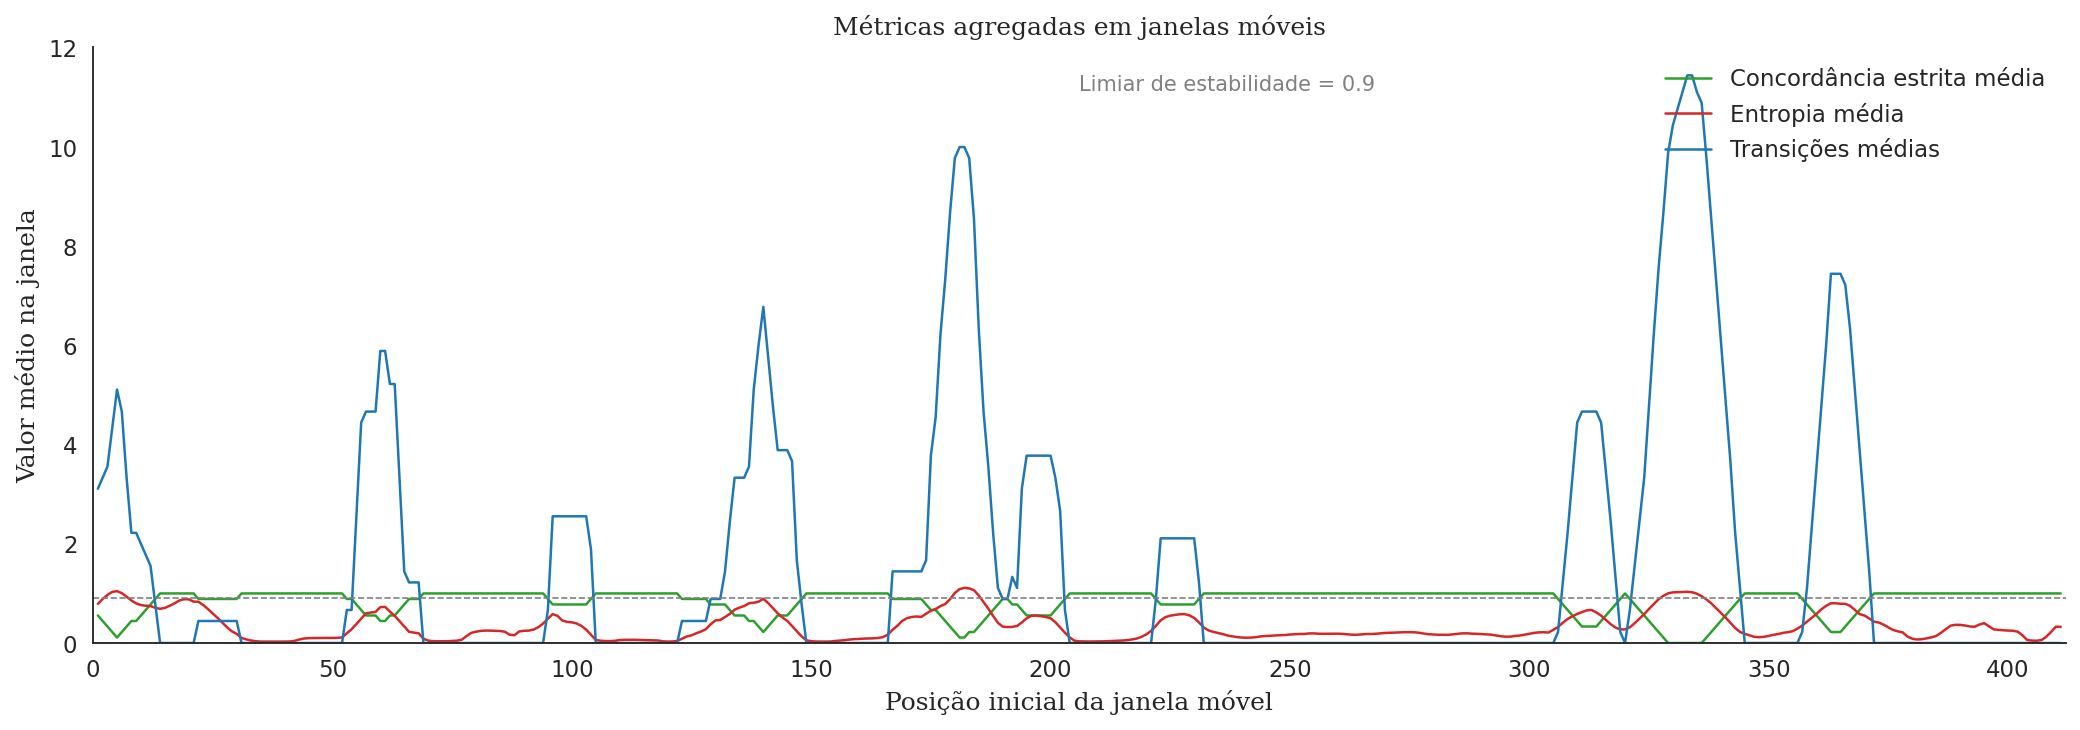

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo para artigo científico
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.linewidth': 0.9,
    'lines.linewidth': 1.2,
    'figure.dpi': 150,
    'axes.grid': False
})

fig, ax = plt.subplots(figsize=(14,5))
sns.set_style('white')

# Plot das métricas
ax.plot(df_janela['start'], df_janela['media_concordancia_estrita'], label='Concordância estrita média', color='#2ca02c')
ax.plot(df_janela['start'], df_janela['media_entropia'], label='Entropia média', color='#d62728')
ax.plot(df_janela['start'], df_janela['media_transicoes'], label='Transições médias', color='#1f77b4')

# Rótulos e título
ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Valor médio na janela')
ax.set_title('Métricas agregadas em janelas móveis')

# Definir limites para garantir 0 nas margens (zero colado aos eixos)
ax.set_xlim(0, df_janela['start'].max() + 1)
ymax = max(df_janela[['media_concordancia_estrita','media_entropia','media_transicoes']].max()) * 1.05
ax.set_ylim(0, ymax)

# Limpar espinhas superiores/direitas e posicionar espinhas esquerda/inferior coladas ao 0
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

# Ticks externos e legenda simples
ax.tick_params(axis='both', which='both', direction='out', length=4)
ax.legend(frameon=False, loc='upper right')

# Limiar de referência
ax.axhline(0.9, color='gray', linestyle='--', linewidth=0.8)
ax.text(0.5, 0.92, 'Limiar de estabilidade = 0.9', transform=ax.transAxes, ha='left', va='bottom', color='gray', fontsize=10)

plt.tight_layout()
plt.show()

## Detalhes da agregação em janelas móveis
Esta célula realiza a agregação das métricas calculadas por posição em janelas móveis ao longo da proteína. Para cada janela (exemplo: 9 resíduos), são calculadas as médias das principais métricas.

**Tabela gerada (`df_window`):**
- `start`: posição inicial da janela na sequência de referência.
- `end`: posição final da janela.
- `mean_hard_concord`: média da concordância estrita na janela (proporção de posições em que todas as variantes concordam no estado secundário).
- `mean_entropy`: média da entropia do consenso na janela (mede a incerteza/dispersão das probabilidades dos estados secundários; valores altos indicam maior divergência entre variantes).
- `mean_cos_sim`: média da similaridade de cosseno entre os vetores de probabilidade das variantes na janela (valores próximos de 1 indicam variantes semelhantes, próximos de 0 indicam divergência).
- `mean_transitions`: média do número de transições de estado secundário entre variantes por posição na janela (mais transições indicam maior discordância estrutural).

Essas médias suavizam o ruído posição a posição e ajudam a identificar regiões estáveis, divergentes ou potencialmente relevantes para função ou fenótipo.

## Detalhes da visualização das métricas agregadas
Esta célula gera gráficos de linha para as principais métricas agregadas em janelas móveis ao longo da proteína.

**Gráficos gerados:**
- **Concordância estrita média**: mostra, para cada janela, a proporção de posições em que todas as variantes concordam no estado secundário (H/E/C). Valores próximos de 1 indicam alta estabilidade estrutural; valores baixos indicam regiões divergentes.
- **Entropia média**: indica o grau de incerteza ou dispersão das probabilidades dos estados secundários entre variantes. Valores altos sugerem maior discordância ou variabilidade estrutural.
- **Transições médias**: mostra o número médio de mudanças de estado secundário entre variantes por posição na janela. Regiões com muitos H↔E/C indicam potencial relevância funcional ou instabilidade.

Esses gráficos permitem identificar rapidamente regiões estáveis, divergentes e potenciais pontos críticos funcionais ou estruturais na proteína.

**Gráfico 1: Métricas agregadas em janelas móveis**
Este gráfico mostra, ao longo da proteína, as médias das principais métricas calculadas em janelas móveis:
- **Concordância estrita média (verde):** Proporção de posições em que todas as variantes concordam no estado secundário. Valores altos indicam regiões estáveis.
- **Entropia média (vermelho):** Mede a incerteza/dispersão das probabilidades dos estados secundários. Valores altos indicam maior divergência entre variantes.
- **Transições médias (azul):** Número médio de mudanças de estado secundário entre variantes por posição. Regiões com muitos H↔E/C indicam potencial relevância funcional ou instabilidade.
A linha cinza tracejada indica o limiar de estabilidade (0,9).

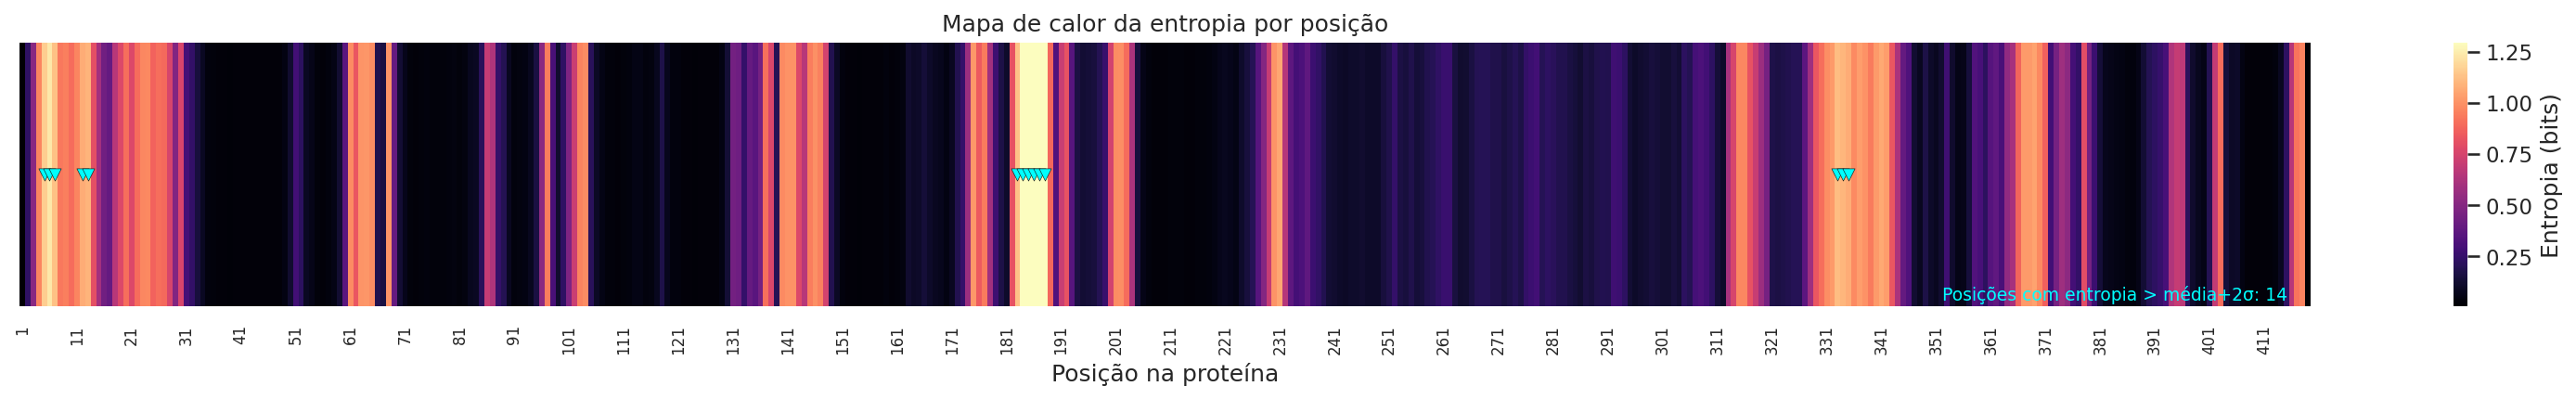

In [61]:
# Heatmap horizontal da entropia por posição com números das posições na vertical
import numpy as np
fig, ax = plt.subplots(figsize=(max(8, len(df_metricas)/20), 3))  # figura larga para leitura horizontal
sns.set_style('white')

# Converter para array 1 x N (heatmap horizontal)
ent = df_metricas['entropia'].values.reshape(1, -1)

# Limites robustos para a cor (evita que outliers comprimam a escala)
vmin = np.nanmin(ent)
vmax = np.nanpercentile(ent, 99)

# Plot do heatmap (1 x N)
im = sns.heatmap(ent, cmap='magma', cbar_kws={'label': 'Entropia (bits)'}, ax=ax,
                 vmin=vmin, vmax=vmax, yticklabels=False)

# Ajustes dos ticks no eixo x: mostrar rótulos a cada step para legibilidade e rotacionar verticalmente
n = ent.shape[1]
step = 10 if n > 200 else (5 if n > 100 else (2 if n > 50 else 1))
xticks = np.arange(0, n, step)
ax.set_xticks(xticks + 0.5)
ax.set_xticklabels((xticks + 1).tolist(), rotation=90, fontsize=8)
ax.set_xlabel('Posição na proteína')
ax.set_title('Mapa de calor da entropia por posição')

# Remover bordas desnecessárias
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

# Identificar posições de alta entropia (ex.: > média + 2*sd) e marcar
mean_e = np.nanmean(ent)
std_e = np.nanstd(ent)
threshold = mean_e + 2 * std_e
high_idx = np.where(ent.flatten() > threshold)[0]
if high_idx.size > 0:
    # marcadores abaixo do heatmap (y=0.5)
    ax.scatter(high_idx + 0.5, np.repeat(0.5, high_idx.size), marker='v',
               color='cyan', s=40, edgecolor='k', linewidth=0.3, zorder=10)
    ax.text(0.99, 0.01, f'Posições com entropia > média+2σ: {len(high_idx)}',
            transform=ax.transAxes, ha='right', va='bottom', fontsize=9, color='cyan')

plt.tight_layout()
plt.show()

**Gráfico 2: Mapa de calor da entropia por posição (vertical)**
Este gráfico apresenta a entropia (incerteza/divergência) das probabilidades dos estados secundários em cada posição da proteína, com as posições dispostas verticalmente para facilitar a leitura em sequências longas.
- O eixo y representa a posição na sequência (resíduos); o eixo x é apenas a coluna do heatmap.
- Tons mais escuros representam maior entropia (maior discordância entre variantes); tons claros indicam maior consenso e estabilidade estrutural.
- O mapa usa limites robustos de cor (percentil 99) para evitar compressão por outliers.
- Posições de 'alta entropia' (definidas como entropia > média + 2σ) são marcadas com triângulos cianos à direita do heatmap; o contador informa quantas posições excedem esse limiar.

Interpretação prática: posições verticais com cor escura e marcador ciano são hotspots de variáveis estrutu- ramente relevantes e merecem investigação adicional (mutações, ligação, dominios).

In [ ]:
# Célula de exportação: salva resultados e figuras para pastas 'results/' e 'figures/'
import os
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Salvar dataframes principais
df_metricas.to_csv(os.path.join('results', 'df_metricas.csv'), index=False)
df_janela.to_csv(os.path.join('results', 'df_janela.csv'), index=False)
print('Dataframes salvos em results/')

# Salvar as figuras atualmente no estado (tenta salvar a figura ativa)
try:
    fig_lines.savefig(os.path.join('figures', 'metrica_janelas.png'), bbox_inches='tight')
    print('Figura de linhas salva em figures/metrica_janelas.png')
except NameError:
    print('Figura de linhas não encontrada (variável fig_lines). Rode a célula de plotagem antes de exportar).')

try:
    fig_heatmap.savefig(os.path.join('figures', 'heatmap_entropia.png'), bbox_inches='tight')
    print('Heatmap salvo em figures/heatmap_entropia.png')
except NameError:
    print('Heatmap não encontrado (variável fig_heatmap). Rode a célula de heatmap antes de exportar).')

try:
    fig_trans.savefig(os.path.join('figures', 'transicoes_barras.png'), bbox_inches='tight')
    print('Gráfico de transições salvo em figures/transicoes_barras.png')
except NameError:
    print('Gráfico de transições não encontrado (variável fig_trans). Rode a célula de barras antes de exportar).')

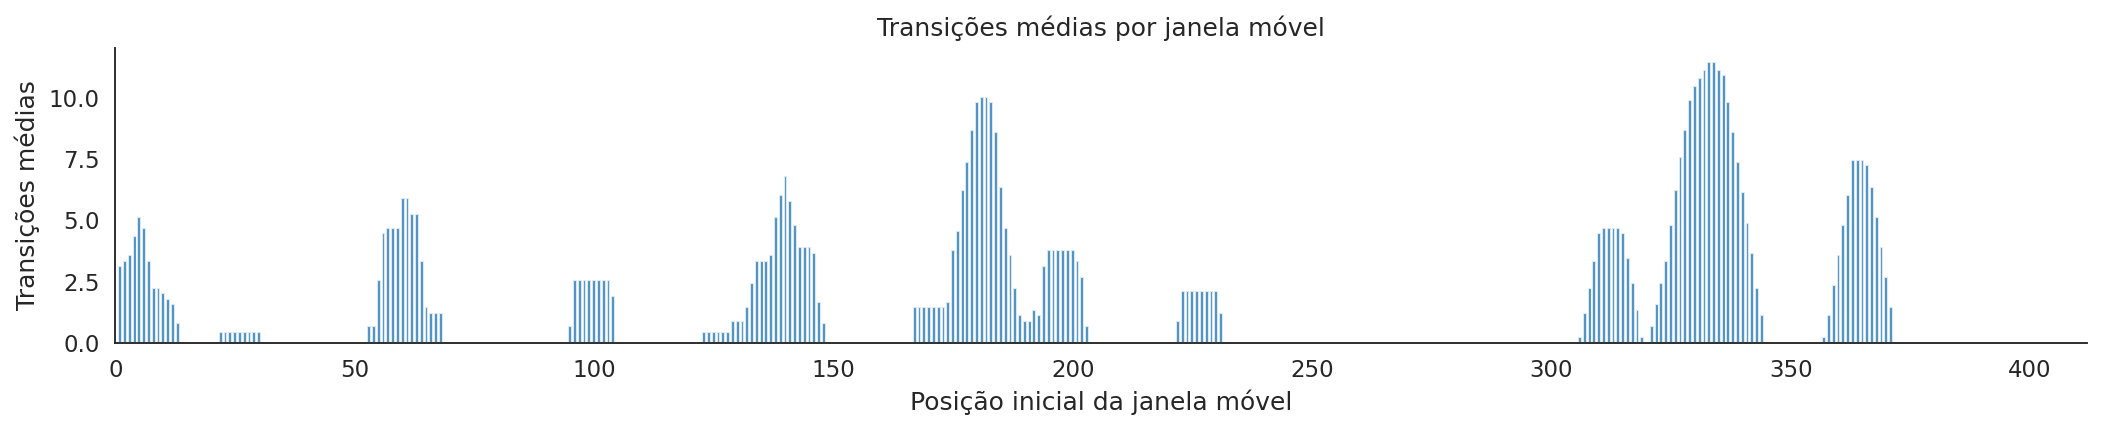

In [62]:
fig, ax = plt.subplots(figsize=(14,3))
sns.set_style('white')

ax.bar(df_janela['start'], df_janela['media_transicoes'], color='#1f77b4', alpha=0.8)

ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Transições médias')
ax.set_title('Transições médias por janela móvel')

ax.set_xlim(0, df_janela['start'].max() + 1)
ax.set_ylim(0, df_janela['media_transicoes'].max() * 1.05)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

ax.tick_params(axis='both', which='both', direction='out', length=4)

plt.tight_layout()
plt.show()

**Gráfico 3: Transições médias por janela móvel**
Este gráfico mostra, para cada janela móvel ao longo da proteína, o número médio de transições de estado secundário entre variantes.
- Barras mais altas indicam regiões com maior discordância estrutural entre variantes (mais mudanças de H↔E/C).
- Barras baixas indicam regiões mais estáveis e conservadas.
Este gráfico é útil para identificar hotspots de variabilidade estrutural e potenciais regiões de interesse funcional.